# Elliptic Curve Cryptography: Theory and Implementation

## 1. Introduction

Elliptic Curve Cryptography (ECC) is a public-key cryptosystem based on the algebraic structure of elliptic curves over finite fields. Introduced independently by Neal Koblitz and Victor Miller in 1985, ECC provides equivalent security to RSA with significantly smaller key sizes, making it particularly attractive for resource-constrained environments.

## 2. Mathematical Foundations

### 2.1 Elliptic Curves over the Real Numbers

An **elliptic curve** over the real numbers is the set of points $(x, y)$ satisfying the **Weierstrass equation**:

$$E: y^2 = x^3 + ax + b$$

where $a, b \in \mathbb{R}$ and the **discriminant** $\Delta$ satisfies:

$$\Delta = -16(4a^3 + 27b^2) \neq 0$$

The non-zero discriminant condition ensures the curve is **non-singular** (has no cusps or self-intersections).

### 2.2 The Group Law on Elliptic Curves

The set of points on an elliptic curve, together with a **point at infinity** $\mathcal{O}$, forms an **abelian group** under a geometrically-defined addition operation.

#### Point Addition ($P + Q$ where $P \neq Q$)

Given two distinct points $P = (x_1, y_1)$ and $Q = (x_2, y_2)$ on the curve:

1. Draw the line through $P$ and $Q$
2. This line intersects the curve at a third point $R'$
3. Reflect $R'$ over the x-axis to get $R = P + Q$

The algebraic formulas are:

$$\lambda = \frac{y_2 - y_1}{x_2 - x_1}$$

$$x_3 = \lambda^2 - x_1 - x_2$$

$$y_3 = \lambda(x_1 - x_3) - y_1$$

#### Point Doubling ($P + P = 2P$)

When adding a point to itself, we use the tangent line at $P = (x_1, y_1)$:

$$\lambda = \frac{3x_1^2 + a}{2y_1}$$

$$x_3 = \lambda^2 - 2x_1$$

$$y_3 = \lambda(x_1 - x_3) - y_1$$

### 2.3 Elliptic Curves over Finite Fields

For cryptographic applications, we work over a **finite field** $\mathbb{F}_p$ where $p$ is a large prime:

$$E(\mathbb{F}_p): y^2 \equiv x^3 + ax + b \pmod{p}$$

All arithmetic operations are performed modulo $p$, and the curve contains a finite number of points.

### 2.4 The Discrete Logarithm Problem (ECDLP)

The security of ECC relies on the **Elliptic Curve Discrete Logarithm Problem**:

> Given points $P$ and $Q = kP$ on an elliptic curve, find the integer $k$.

This problem is believed to be computationally intractable for properly chosen curves and large $k$.

## 3. Cryptographic Protocols

### 3.1 Elliptic Curve Diffie-Hellman (ECDH)

Key exchange protocol:
1. Alice and Bob agree on curve $E$ and base point $G$
2. Alice chooses private key $a$, computes public key $A = aG$
3. Bob chooses private key $b$, computes public key $B = bG$
4. Shared secret: $S = aB = bA = abG$

### 3.2 Elliptic Curve Digital Signature Algorithm (ECDSA)

Digital signature scheme using the curve's group structure for authentication.

## 4. Implementation

We now implement elliptic curve operations and visualize the geometric interpretation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import warnings
warnings.filterwarnings('ignore')

# Set up matplotlib parameters for publication-quality figures
plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14

### 4.1 Elliptic Curve Class for Real Numbers

In [2]:
class EllipticCurveReal:
    """
    Elliptic curve over real numbers: y^2 = x^3 + ax + b
    """
    
    def __init__(self, a, b):
        self.a = a
        self.b = b
        # Check discriminant
        self.discriminant = -16 * (4 * a**3 + 27 * b**2)
        if abs(self.discriminant) < 1e-10:
            raise ValueError("Singular curve (discriminant = 0)")
    
    def __repr__(self):
        return f"y² = x³ + {self.a}x + {self.b}"
    
    def is_on_curve(self, x, y, tol=1e-9):
        """Check if point (x, y) lies on the curve."""
        return abs(y**2 - (x**3 + self.a * x + self.b)) < tol
    
    def y_from_x(self, x):
        """Compute y values for given x (returns both roots if they exist)."""
        val = x**3 + self.a * x + self.b
        if val < 0:
            return None, None
        y = np.sqrt(val)
        return y, -y
    
    def add_points(self, P, Q):
        """
        Add two points on the elliptic curve.
        P and Q are tuples (x, y) or None for point at infinity.
        """
        # Handle point at infinity
        if P is None:
            return Q
        if Q is None:
            return P
        
        x1, y1 = P
        x2, y2 = Q
        
        # Check if points are inverses (P + (-P) = O)
        if abs(x1 - x2) < 1e-10 and abs(y1 + y2) < 1e-10:
            return None  # Point at infinity
        
        # Point doubling
        if abs(x1 - x2) < 1e-10 and abs(y1 - y2) < 1e-10:
            if abs(y1) < 1e-10:
                return None  # Tangent is vertical
            lam = (3 * x1**2 + self.a) / (2 * y1)
        else:
            # Point addition
            lam = (y2 - y1) / (x2 - x1)
        
        x3 = lam**2 - x1 - x2
        y3 = lam * (x1 - x3) - y1
        
        return (x3, y3)
    
    def scalar_mult(self, k, P):
        """Compute kP using double-and-add algorithm."""
        if k == 0 or P is None:
            return None
        if k < 0:
            k = -k
            P = (P[0], -P[1])
        
        result = None
        addend = P
        
        while k:
            if k & 1:
                result = self.add_points(result, addend)
            addend = self.add_points(addend, addend)
            k >>= 1
        
        return result

# Create example curve: y^2 = x^3 - x + 1
curve_real = EllipticCurveReal(a=-1, b=1)
print(f"Curve: {curve_real}")
print(f"Discriminant: Δ = {curve_real.discriminant:.2f}")

Curve: y² = x³ + -1x + 1
Discriminant: Δ = -368.00


### 4.2 Visualization of Elliptic Curve and Point Addition

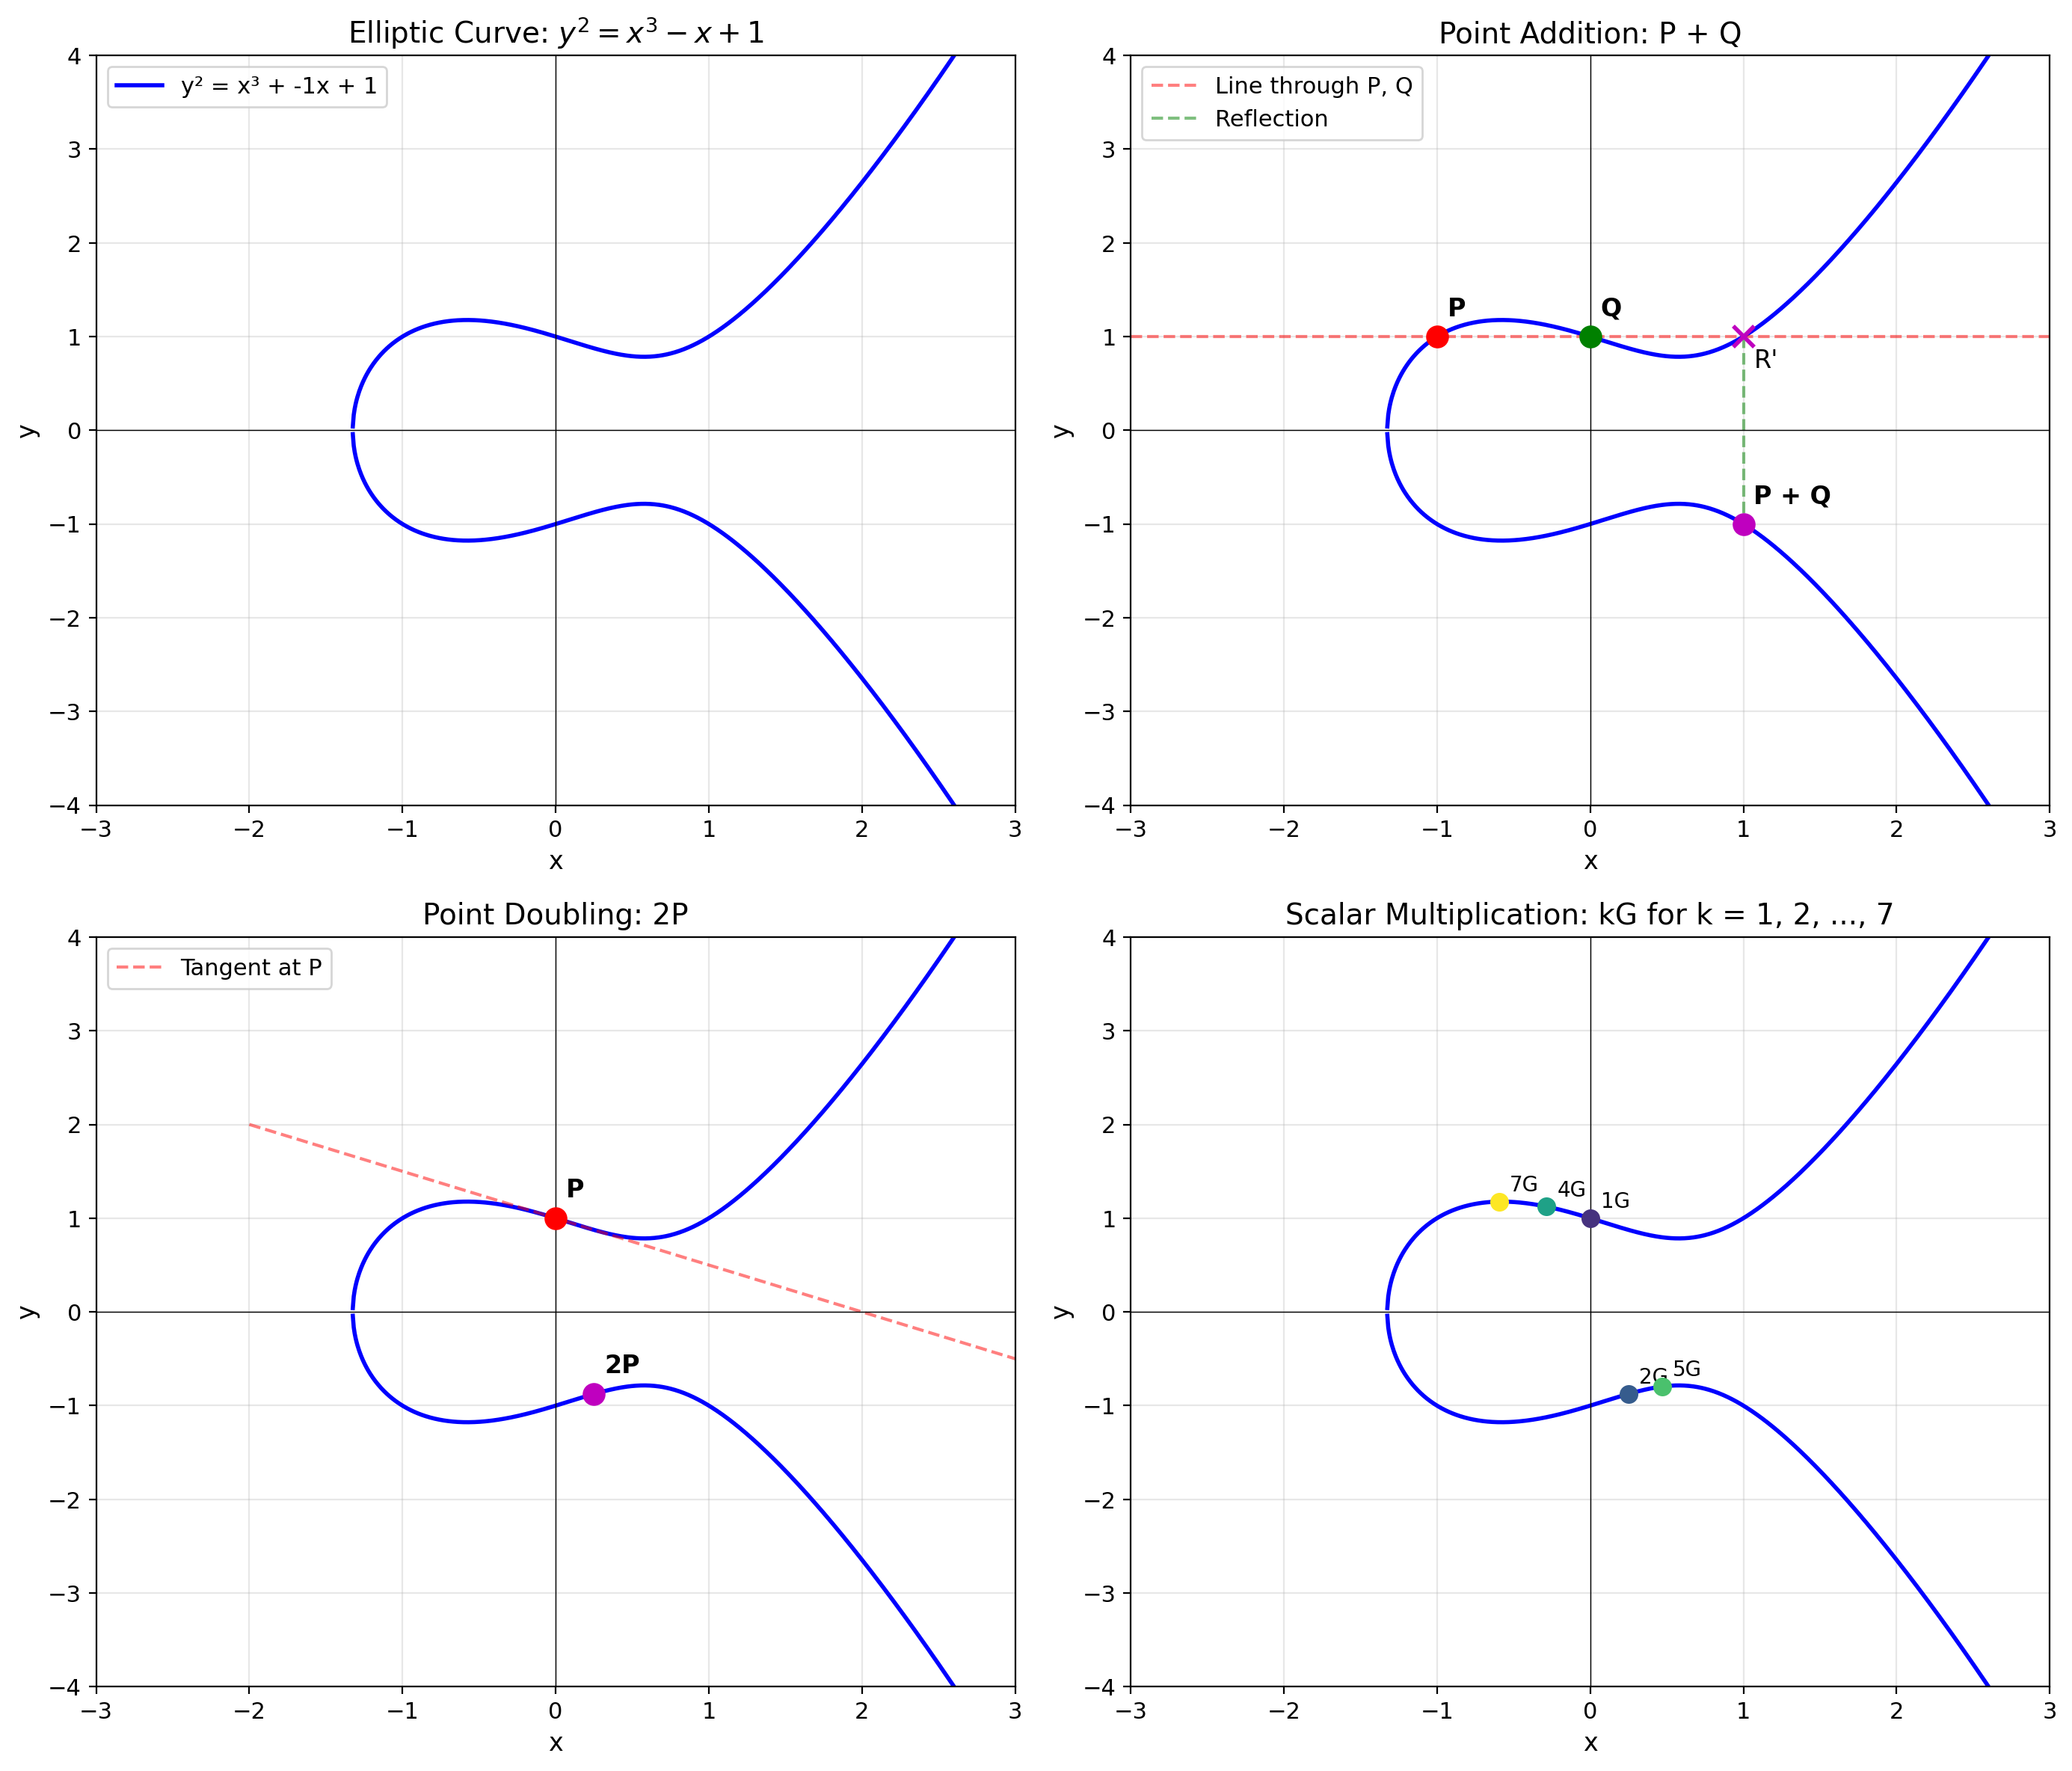


Scalar multiplication results:
  1G = (0.0000, 1.0000)
  2G = (0.2500, -0.8750)
  3G = (56.0000, 419.0000)
  4G = (-0.2844, 1.1231)
  5G = (0.4718, -0.7957)
  6G = (14.0127, 52.3302)
  7G = (-0.5942, 1.1766)


In [3]:
def plot_elliptic_curve(curve, ax, x_range=(-3, 3), color='blue', label=None):
    """Plot an elliptic curve over the reals."""
    x = np.linspace(x_range[0], x_range[1], 1000)
    
    # Compute y^2 values
    y_squared = x**3 + curve.a * x + curve.b
    
    # Only plot where y^2 >= 0
    mask = y_squared >= 0
    x_valid = x[mask]
    y_pos = np.sqrt(y_squared[mask])
    y_neg = -y_pos
    
    # Plot both branches
    ax.plot(x_valid, y_pos, color=color, linewidth=2, label=label)
    ax.plot(x_valid, y_neg, color=color, linewidth=2)

def visualize_point_addition(curve, P, Q, ax):
    """Visualize the geometric addition of two points."""
    # Compute R = P + Q
    R = curve.add_points(P, Q)
    
    if R is None:
        return None
    
    # R' is the third intersection point (before reflection)
    R_prime = (R[0], -R[1])
    
    # Plot points
    ax.plot(*P, 'ro', markersize=10, zorder=5)
    ax.plot(*Q, 'go', markersize=10, zorder=5)
    ax.plot(*R, 'mo', markersize=10, zorder=5)
    ax.plot(*R_prime, 'mx', markersize=10, zorder=5, markeredgewidth=2)
    
    # Labels
    ax.annotate('P', P, xytext=(5, 10), textcoords='offset points', fontsize=12, fontweight='bold')
    ax.annotate('Q', Q, xytext=(5, 10), textcoords='offset points', fontsize=12, fontweight='bold')
    ax.annotate('P + Q', R, xytext=(5, 10), textcoords='offset points', fontsize=12, fontweight='bold')
    ax.annotate("R'", R_prime, xytext=(5, -15), textcoords='offset points', fontsize=12)
    
    # Line through P and Q (extended)
    if abs(P[0] - Q[0]) > 1e-10:
        slope = (Q[1] - P[1]) / (Q[0] - P[0])
        intercept = P[1] - slope * P[0]
        x_line = np.linspace(-3, 3, 100)
        y_line = slope * x_line + intercept
        ax.plot(x_line, y_line, 'r--', alpha=0.5, linewidth=1.5, label='Line through P, Q')
    
    # Vertical line for reflection
    ax.plot([R[0], R[0]], [R_prime[1], R[1]], 'g--', alpha=0.5, linewidth=1.5, label='Reflection')
    
    return R

# Create figure for point addition visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Panel 1: Basic elliptic curve
ax1 = axes[0, 0]
plot_elliptic_curve(curve_real, ax1, label=str(curve_real))
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Elliptic Curve: $y^2 = x^3 - x + 1$')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-3, 3)
ax1.set_ylim(-4, 4)

# Panel 2: Point addition P + Q
ax2 = axes[0, 1]
plot_elliptic_curve(curve_real, ax2)
P = (-1, 1)
Q = (0, 1)
R = visualize_point_addition(curve_real, P, Q, ax2)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.axvline(x=0, color='k', linewidth=0.5)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Point Addition: P + Q')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-3, 3)
ax2.set_ylim(-4, 4)

# Panel 3: Point doubling 2P
ax3 = axes[1, 0]
plot_elliptic_curve(curve_real, ax3)
P_double = (0, 1)
P2 = curve_real.add_points(P_double, P_double)
ax3.plot(*P_double, 'ro', markersize=10, zorder=5)
ax3.plot(*P2, 'mo', markersize=10, zorder=5)
ax3.annotate('P', P_double, xytext=(5, 10), textcoords='offset points', fontsize=12, fontweight='bold')
ax3.annotate('2P', P2, xytext=(5, 10), textcoords='offset points', fontsize=12, fontweight='bold')

# Tangent line at P
x1, y1 = P_double
slope_tangent = (3 * x1**2 + curve_real.a) / (2 * y1)
intercept_tangent = y1 - slope_tangent * x1
x_tang = np.linspace(-2, 3, 100)
y_tang = slope_tangent * x_tang + intercept_tangent
ax3.plot(x_tang, y_tang, 'r--', alpha=0.5, linewidth=1.5, label='Tangent at P')

ax3.axhline(y=0, color='k', linewidth=0.5)
ax3.axvline(x=0, color='k', linewidth=0.5)
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_title('Point Doubling: 2P')
ax3.legend(loc='upper left')
ax3.grid(True, alpha=0.3)
ax3.set_xlim(-3, 3)
ax3.set_ylim(-4, 4)

# Panel 4: Scalar multiplication sequence
ax4 = axes[1, 1]
plot_elliptic_curve(curve_real, ax4)
G = (0, 1)  # Generator point
colors = plt.cm.viridis(np.linspace(0, 1, 8))

for k in range(1, 8):
    kG = curve_real.scalar_mult(k, G)
    if kG is not None:
        ax4.plot(*kG, 'o', color=colors[k], markersize=8, zorder=5)
        ax4.annotate(f'{k}G', kG, xytext=(5, 5), textcoords='offset points', fontsize=10)

ax4.axhline(y=0, color='k', linewidth=0.5)
ax4.axvline(x=0, color='k', linewidth=0.5)
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_title('Scalar Multiplication: kG for k = 1, 2, ..., 7')
ax4.grid(True, alpha=0.3)
ax4.set_xlim(-3, 3)
ax4.set_ylim(-4, 4)

plt.tight_layout()
plt.savefig('elliptic_curves_cryptography_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nScalar multiplication results:")
for k in range(1, 8):
    kG = curve_real.scalar_mult(k, G)
    if kG:
        print(f"  {k}G = ({kG[0]:.4f}, {kG[1]:.4f})")

### 4.3 Elliptic Curves over Finite Fields

For cryptographic applications, we implement curves over $\mathbb{F}_p$.

In [4]:
def mod_inverse(a, p):
    """Compute modular inverse using extended Euclidean algorithm."""
    if a == 0:
        raise ValueError("No inverse exists for 0")
    
    g, x, _ = extended_gcd(a % p, p)
    if g != 1:
        raise ValueError(f"No inverse exists for {a} mod {p}")
    return x % p

def extended_gcd(a, b):
    """Extended Euclidean Algorithm."""
    if a == 0:
        return b, 0, 1
    gcd, x1, y1 = extended_gcd(b % a, a)
    x = y1 - (b // a) * x1
    y = x1
    return gcd, x, y

class EllipticCurveFp:
    """
    Elliptic curve over finite field F_p: y^2 = x^3 + ax + b (mod p)
    """
    
    def __init__(self, a, b, p):
        self.a = a % p
        self.b = b % p
        self.p = p
        
        # Check discriminant
        discriminant = (-16 * (4 * a**3 + 27 * b**2)) % p
        if discriminant == 0:
            raise ValueError("Singular curve")
    
    def __repr__(self):
        return f"y² ≡ x³ + {self.a}x + {self.b} (mod {self.p})"
    
    def is_on_curve(self, point):
        """Check if point is on the curve."""
        if point is None:  # Point at infinity
            return True
        x, y = point
        return (y * y - (x**3 + self.a * x + self.b)) % self.p == 0
    
    def add_points(self, P, Q):
        """Add two points on the curve."""
        if P is None:
            return Q
        if Q is None:
            return P
        
        x1, y1 = P
        x2, y2 = Q
        
        if x1 == x2 and (y1 + y2) % self.p == 0:
            return None  # Point at infinity
        
        if x1 == x2 and y1 == y2:
            # Point doubling
            if y1 == 0:
                return None
            lam = ((3 * x1**2 + self.a) * mod_inverse(2 * y1, self.p)) % self.p
        else:
            # Point addition
            lam = ((y2 - y1) * mod_inverse(x2 - x1, self.p)) % self.p
        
        x3 = (lam**2 - x1 - x2) % self.p
        y3 = (lam * (x1 - x3) - y1) % self.p
        
        return (x3, y3)
    
    def scalar_mult(self, k, P):
        """Compute kP using double-and-add."""
        if k == 0 or P is None:
            return None
        if k < 0:
            k = -k
            P = (P[0], (-P[1]) % self.p)
        
        result = None
        addend = P
        
        while k:
            if k & 1:
                result = self.add_points(result, addend)
            addend = self.add_points(addend, addend)
            k >>= 1
        
        return result
    
    def get_all_points(self):
        """Find all points on the curve (for small p)."""
        points = [None]  # Include point at infinity
        
        for x in range(self.p):
            y_squared = (x**3 + self.a * x + self.b) % self.p
            
            # Check if y_squared is a quadratic residue
            for y in range(self.p):
                if (y * y) % self.p == y_squared:
                    points.append((x, y))
        
        return points

# Example: Small curve for demonstration
# E: y^2 = x^3 + 2x + 3 over F_97
p = 97
curve_fp = EllipticCurveFp(a=2, b=3, p=p)
print(f"Curve: {curve_fp}")

# Find all points
points = curve_fp.get_all_points()
print(f"Number of points (including O): {len(points)}")
print(f"\nFirst 10 finite points:")
for pt in points[1:11]:
    print(f"  {pt}")

Curve: y² ≡ x³ + 2x + 3 (mod 97)
Number of points (including O): 100

First 10 finite points:
  (0, 10)
  (0, 87)
  (1, 43)
  (1, 54)
  (3, 6)
  (3, 91)
  (4, 47)
  (4, 50)
  (10, 21)
  (10, 76)


### 4.4 Demonstration: Elliptic Curve Diffie-Hellman (ECDH)

In [5]:
def ecdh_demo(curve, G):
    """
    Demonstrate Elliptic Curve Diffie-Hellman key exchange.
    """
    print("="*60)
    print("ELLIPTIC CURVE DIFFIE-HELLMAN (ECDH) KEY EXCHANGE")
    print("="*60)
    print(f"\nPublic Parameters:")
    print(f"  Curve: {curve}")
    print(f"  Generator G: {G}")
    
    # Alice's key pair
    np.random.seed(42)  # For reproducibility
    alice_private = np.random.randint(2, curve.p - 1)
    alice_public = curve.scalar_mult(alice_private, G)
    
    print(f"\nAlice:")
    print(f"  Private key (a): {alice_private}")
    print(f"  Public key (A = aG): {alice_public}")
    
    # Bob's key pair
    bob_private = np.random.randint(2, curve.p - 1)
    bob_public = curve.scalar_mult(bob_private, G)
    
    print(f"\nBob:")
    print(f"  Private key (b): {bob_private}")
    print(f"  Public key (B = bG): {bob_public}")
    
    # Shared secret computation
    alice_shared = curve.scalar_mult(alice_private, bob_public)  # a * B = a * bG
    bob_shared = curve.scalar_mult(bob_private, alice_public)    # b * A = b * aG
    
    print(f"\nShared Secret Computation:")
    print(f"  Alice computes: a × B = {alice_private} × {bob_public}")
    print(f"                       = {alice_shared}")
    print(f"  Bob computes:   b × A = {bob_private} × {alice_public}")
    print(f"                       = {bob_shared}")
    
    if alice_shared == bob_shared:
        print(f"\n✓ SUCCESS: Both parties computed the same shared secret!")
        print(f"  Shared Secret S = {alice_shared}")
    else:
        print(f"\n✗ ERROR: Shared secrets don't match!")
    
    return alice_shared

# Use a generator point on our curve
G = (3, 6)  # A point on the curve
assert curve_fp.is_on_curve(G), "G is not on the curve!"

shared_secret = ecdh_demo(curve_fp, G)

ELLIPTIC CURVE DIFFIE-HELLMAN (ECDH) KEY EXCHANGE

Public Parameters:
  Curve: y² ≡ x³ + 2x + 3 (mod 97)
  Generator G: (3, 6)

Alice:
  Private key (a): 53
  Public key (A = aG): (80, 87)

Bob:
  Private key (b): 94
  Public key (B = bG): (3, 91)

Shared Secret Computation:
  Alice computes: a × B = 53 × (3, 91)
                       = (80, 10)
  Bob computes:   b × A = 94 × (80, 87)
                       = (80, 10)

✓ SUCCESS: Both parties computed the same shared secret!
  Shared Secret S = (80, 10)


### 4.5 Visualization of Finite Field Curve

Curve: y² ≡ x³ + 1x + 1 (mod 23)
Number of points: 28


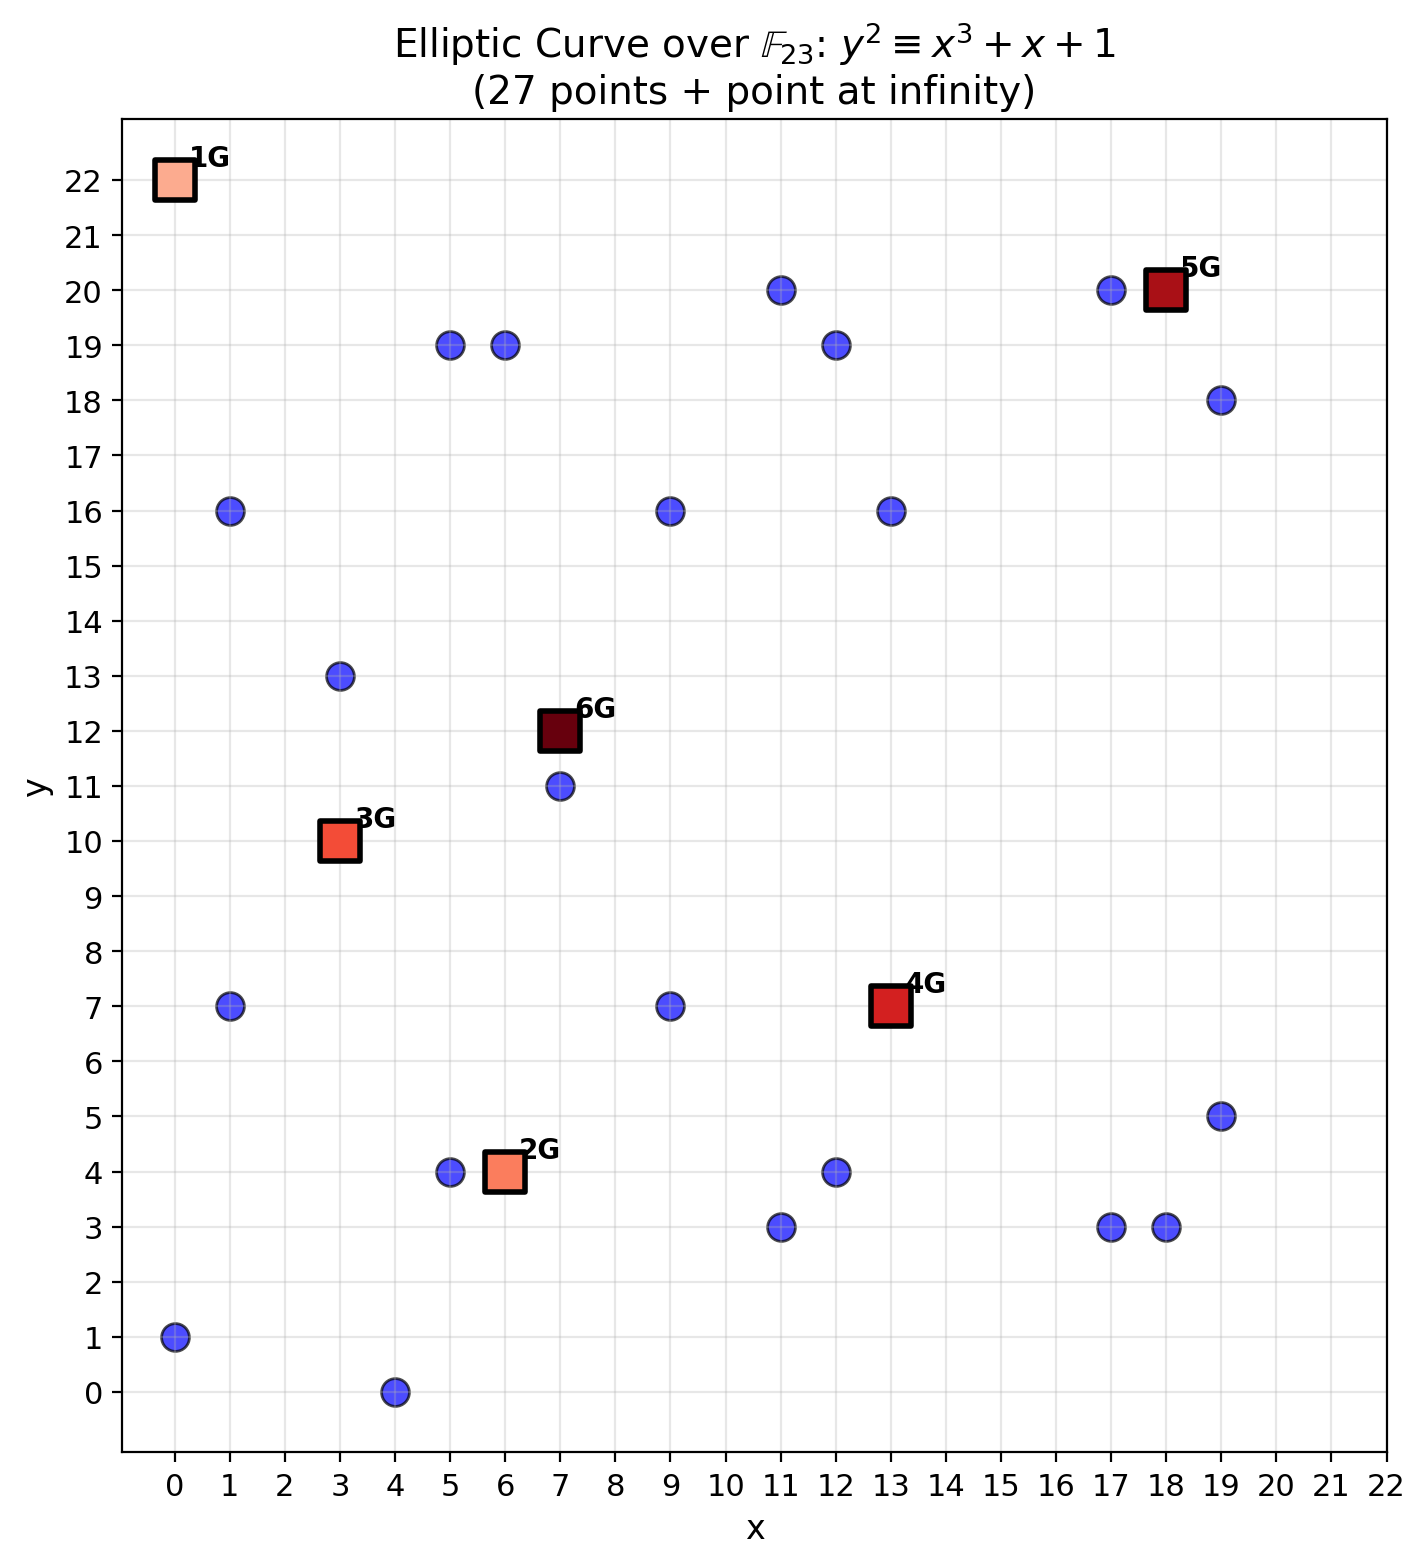

In [6]:
# Use a smaller prime for clearer visualization
p_small = 23
curve_small = EllipticCurveFp(a=1, b=1, p=p_small)
points_small = curve_small.get_all_points()

print(f"Curve: {curve_small}")
print(f"Number of points: {len(points_small)}")

# Plot the finite field curve
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Extract x and y coordinates (excluding point at infinity)
finite_points = [p for p in points_small if p is not None]
xs = [p[0] for p in finite_points]
ys = [p[1] for p in finite_points]

ax.scatter(xs, ys, c='blue', s=100, alpha=0.7, edgecolors='black', linewidths=1)

# Highlight a generator and some multiples
G_small = finite_points[1]  # Pick a generator
colors_mult = plt.cm.Reds(np.linspace(0.3, 1, 6))

for k in range(1, 7):
    kG = curve_small.scalar_mult(k, G_small)
    if kG is not None:
        ax.scatter(*kG, c=[colors_mult[k-1]], s=200, marker='s', 
                   edgecolors='black', linewidths=2, zorder=5)
        ax.annotate(f'{k}G', kG, xytext=(5, 5), textcoords='offset points', 
                    fontsize=10, fontweight='bold')

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title(f'Elliptic Curve over $\\mathbb{{F}}_{{{p_small}}}$: $y^2 \\equiv x^3 + x + 1$\n'
             f'({len(finite_points)} points + point at infinity)', fontsize=14)
ax.set_xticks(range(p_small))
ax.set_yticks(range(p_small))
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('elliptic_curves_cryptography_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

### 4.6 Security Analysis: Order of Points and Subgroups

In [7]:
def find_point_order(curve, P):
    """Find the order of point P (smallest k such that kP = O)."""
    if P is None:
        return 1
    
    current = P
    order = 1
    
    while current is not None:
        current = curve.add_points(current, P)
        order += 1
        if order > curve.p + 1 + 2 * int(np.sqrt(curve.p)):  # Hasse bound
            return None  # Something went wrong
    
    return order

# Analyze the order of points on our small curve
print(f"Point Order Analysis for {curve_small}")
print("="*50)

orders = {}
for pt in finite_points[:15]:  # Analyze first 15 points
    order = find_point_order(curve_small, pt)
    orders[pt] = order
    print(f"Point {pt}: order = {order}")

# Find generators (points with maximum order)
max_order = max(orders.values())
generators = [pt for pt, ord_ in orders.items() if ord_ == max_order]

print(f"\nGroup order (number of points): {len(points_small)}")
print(f"Maximum point order: {max_order}")
print(f"Generators (points of maximum order): {generators[:3]}...")

Point Order Analysis for y² ≡ x³ + 1x + 1 (mod 23)
Point (0, 1): order = 28
Point (0, 22): order = 28
Point (1, 7): order = 28
Point (1, 16): order = 28
Point (3, 10): order = 28
Point (3, 13): order = 28
Point (4, 0): order = 2
Point (5, 4): order = 7
Point (5, 19): order = 7
Point (6, 4): order = 14
Point (6, 19): order = 14
Point (7, 11): order = 14
Point (7, 12): order = 14
Point (9, 7): order = 28
Point (9, 16): order = 28

Group order (number of points): 28
Maximum point order: 28
Generators (points of maximum order): [(0, 1), (0, 22), (1, 7)]...


## 5. Standard Curves in Practice

Real-world ECC uses standardized curves with carefully chosen parameters. Here we examine **secp256k1**, used by Bitcoin.

In [8]:
# secp256k1 parameters (used by Bitcoin)
secp256k1_params = {
    'name': 'secp256k1',
    'p': 0xFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFEFFFFFC2F,
    'a': 0,
    'b': 7,
    'Gx': 0x79BE667EF9DCBBAC55A06295CE870B07029BFCDB2DCE28D959F2815B16F81798,
    'Gy': 0x483ADA7726A3C4655DA4FBFC0E1108A8FD17B448A68554199C47D08FFB10D4B8,
    'n': 0xFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFEBAAEDCE6AF48A03BBFD25E8CD0364141,  # Order
}

print("secp256k1 Curve Parameters (Bitcoin)")
print("="*60)
print(f"\nCurve equation: y² = x³ + {secp256k1_params['a']}x + {secp256k1_params['b']}")
print(f"\nPrime field size (p):")
print(f"  {secp256k1_params['p']}")
print(f"  (2²⁵⁶ - 2³² - 977)")
print(f"  Bit length: {secp256k1_params['p'].bit_length()} bits")

print(f"\nGenerator point G:")
print(f"  x = {hex(secp256k1_params['Gx'])}")
print(f"  y = {hex(secp256k1_params['Gy'])}")

print(f"\nOrder n (number of points in subgroup):")
print(f"  {secp256k1_params['n']}")
print(f"  Bit length: {secp256k1_params['n'].bit_length()} bits")

# Security comparison
print(f"\n" + "="*60)
print("Security Comparison: ECC vs RSA")
print("="*60)
print(f"\n{'ECC Key Size':<20} {'RSA Equivalent':<20} {'Security Level':<20}")
print("-"*60)
comparisons = [
    ('160 bits', '1024 bits', '80 bits'),
    ('224 bits', '2048 bits', '112 bits'),
    ('256 bits', '3072 bits', '128 bits'),
    ('384 bits', '7680 bits', '192 bits'),
    ('521 bits', '15360 bits', '256 bits'),
]
for ecc, rsa, sec in comparisons:
    print(f"{ecc:<20} {rsa:<20} {sec:<20}")

print(f"\nsecp256k1 provides ~128 bits of security with 256-bit keys,")
print(f"equivalent to 3072-bit RSA but with much smaller key sizes.")

secp256k1 Curve Parameters (Bitcoin)

Curve equation: y² = x³ + 0x + 7

Prime field size (p):
  115792089237316195423570985008687907853269984665640564039457584007908834671663
  (2²⁵⁶ - 2³² - 977)
  Bit length: 256 bits

Generator point G:
  x = 0x79be667ef9dcbbac55a06295ce870b07029bfcdb2dce28d959f2815b16f81798
  y = 0x483ada7726a3c4655da4fbfc0e1108a8fd17b448a68554199c47d08ffb10d4b8

Order n (number of points in subgroup):
  115792089237316195423570985008687907852837564279074904382605163141518161494337
  Bit length: 256 bits

Security Comparison: ECC vs RSA

ECC Key Size         RSA Equivalent       Security Level      
------------------------------------------------------------
160 bits             1024 bits            80 bits             
224 bits             2048 bits            112 bits            
256 bits             3072 bits            128 bits            
384 bits             7680 bits            192 bits            
521 bits             15360 bits           256 bits          

## 6. Conclusions

This notebook has demonstrated the mathematical foundations and implementation of Elliptic Curve Cryptography:

1. **Group Structure**: Elliptic curves form abelian groups under point addition, providing the algebraic structure necessary for cryptography.

2. **ECDLP Security**: The discrete logarithm problem on elliptic curves is believed to be computationally hard, forming the security basis for ECC.

3. **Efficiency**: ECC provides equivalent security to RSA with significantly smaller key sizes (256-bit ECC ≈ 3072-bit RSA).

4. **Key Applications**:
   - **ECDH**: Secure key exchange
   - **ECDSA**: Digital signatures (used in Bitcoin, TLS)
   - **ECIES**: Integrated encryption scheme

### References

- Koblitz, N. (1987). "Elliptic curve cryptosystems". *Mathematics of Computation*.
- Miller, V. (1985). "Use of elliptic curves in cryptography". *CRYPTO '85*.
- Hankerson, D., Menezes, A., & Vanstone, S. (2004). *Guide to Elliptic Curve Cryptography*. Springer.